In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import torch

In [ ]:
train_path = Path("D:/CSE BRACU/CSE428/CSE428-Image-Processing-Project/Dataset_Group1/train")
test_path = Path("D:/CSE BRACU/CSE428/CSE428-Image-Processing-Project/Dataset_Group1/test")

In [ ]:
def load_images(folder_path):
    images = [] # x
    labels = [] # y
    class_dict = {}

    for sub_folder_path in folder_path.iterdir():
        if sub_folder_path.is_dir():
            class_name = sub_folder_path.name
            class_images = []

            count = 0
            for img_path in sub_folder_path.iterdir():
                image = load_img(img_path,target_size=(224, 224))
                image_array = img_to_array(image)

                images.append(image_array)
                labels.append(class_name)
                class_images.append(image_array)
                count+=1

            class_dict[class_name] = count

    unique_labels = np.unique(labels)

    return [[np.array(images), np.array(labels)], class_dict, unique_labels]

In [ ]:
# loading the train and test data as numpy array and giving label to the train data

dataset, class_dict, labels_list = load_images(train_path)
X_train_org, Y_train_org = dataset
number_of_classes = len(labels_list)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_org, Y_train_org, test_size=0.2, random_state=428)
X_test, Y_test = load_images(test_path)[0]

In [ ]:
print(f'Train set {X_train.shape} and {Y_train.shape}')
print(f'Test set {X_test.shape} and {Y_test.shape}')
print(f'Validation set {X_validation.shape} and {Y_validation.shape}')

Train set (2000, 224, 224, 3) and (2000,)
Test set (250, 224, 224, 3) and (250,)
Validation set (500, 224, 224, 3) and (500,)


**Data Augmentation**

In [ ]:
def data_augmentation(folder_path):
    folder_path = Path(folder_path)
    max_sample = max([len(list(class_folder.iterdir())) for class_folder in folder_path.iterdir()])

    datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    for sub_folder_path in folder_path.iterdir():
        if sub_folder_path.is_dir():
            class_name = sub_folder_path.name
            augmentation_num = max_sample - len(list(sub_folder_path.iterdir()))
            if augmentation_num <= 0:
                continue

            count = 0
            for img_path in sub_folder_path.iterdir():
                if count > augmentation_num:
                    break
                count += 1

                img = load_img(img_path)                  # Load the image
                x = img_to_array(img)                     # Convert to numpy array
                x = x.reshape((1,) + x.shape)             # Reshape it

                i = 0
                for _ in datagen.flow(x, batch_size=1, save_to_dir=str(sub_folder_path), save_prefix='img', save_format='jpeg'):
                    i += 1
                    if i >= 1:
                        break

In [ ]:
# after data augmentation
data_augmentation(train_path)
sample_num = load_images(train_path)[1]
print(sample_num)

{'bear': 500, 'boa-constrictor': 500, 'bullfrog': 500, 'golden-retriever': 500, 'goldfish': 500}


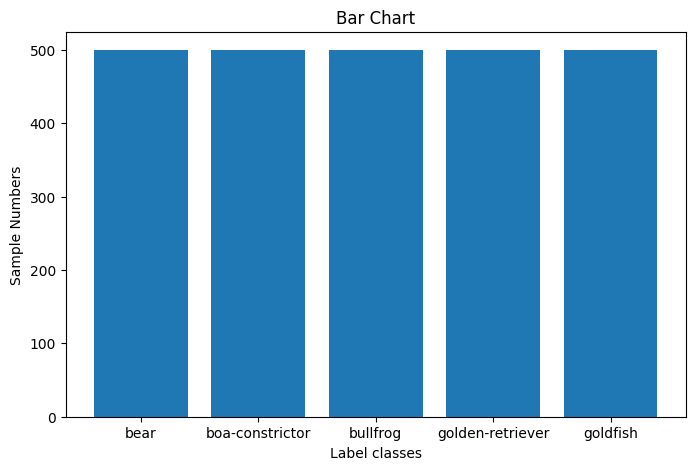

In [ ]:
x = list(sample_num.keys())
y = list(sample_num.values())

plt.figure(figsize=(8, 5))
plt.bar(x, y)
plt.xlabel('Label classes')
plt.ylabel('Sample Numbers')
plt.title('Bar Chart')
plt.show()

**Feature and One hot encoding**

In [ ]:
X_train_org, Y_train_org = load_images(train_path)[0]
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_org, Y_train_org, test_size=0.2, random_state=428)
X_test, Y_test = load_images(test_path)[0]

In [ ]:
# Encoding
label_encoder = LabelEncoder()
Y_train_org_int = label_encoder.fit_transform(Y_train_org)
Y_test_int = label_encoder.fit_transform(Y_test)
Y_validation_int = label_encoder.fit_transform(Y_validation)

# One hot encoding
Y_train_org_ohe = tf.keras.utils.to_categorical(Y_train_org_int, num_classes = number_of_classes)
Y_test_ohe = tf.keras.utils.to_categorical(Y_test_int, num_classes = number_of_classes)
Y_validation_ohe = tf.keras.utils.to_categorical(Y_validation_int, num_classes = number_of_classes)


**ResNet-34 Model**

In [ ]:
def conv2d(filters, kernel_size, strides=1, padding='same'):
    return tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)

def basic_block(x, filters, strides=1):
    shortcut = x

    # First convolution
    x = conv2d(filters, 3, strides=strides)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Second convolution
    x = conv2d(filters, 3)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Shortcut connection
    if strides != 1:
        shortcut = conv2d(filters, 1, strides=strides)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

def resnet34(input_shape=(224, 224, 3), num_classes=5):
    inputs = tf.keras.Input(shape=input_shape)
    x = conv2d(64, 7, strides=2)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Layer configurations for ResNet-34
    layer_configs = [(64, 3, 1), (128, 4, 2), (256, 6, 2), (512, 3, 2)]
    for (filters, blocks, strides) in layer_configs:
        for i in range(blocks):
            x = basic_block(x, filters, strides if i == 0 else 1)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = resnet34()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9408      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [ ]:
model = resnet34(input_shape=(224, 224, 3), num_classes=5)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 10
checkpoint_filepath = "D:/CSE BRACU/CSE428/CSE428-Image-Processing-Project"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
history = model.fit(X_train_org, Y_train_org_ohe, validation_data=(X_test, Y_test_ohe),  verbose=1, epochs=EPOCHS, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/10
79/79 [==============================] - 775s 10s/step - loss: 1.7933 - accuracy: 0.3988 - val_loss: 1025.7996 - val_accuracy: 0.2000
Epoch 2/10
79/79 [==============================] - 717s 9s/step - loss: 1.2004 - accuracy: 0.5200 - val_loss: 5.8632 - val_accuracy: 0.1760
Epoch 3/10
79/79 [==============================] - 735s 9s/step - loss: 1.0202 - accuracy: 0.6012 - val_loss: 1.8390 - val_accuracy: 0.3760
Epoch 4/10
79/79 [==============================] - 702s 9s/step - loss: 0.9942 - accuracy: 0.6212 - val_loss: 1.3860 - val_accuracy: 0.4520
Epoch 5/10
79/79 [==============================] - 705s 9s/step - loss: 0.9310 - accuracy: 0.6488 - val_loss: 1.4193 - val_accuracy: 0.5280
Epoch 6/10
79/79 [==============================] - 707s 9s/step - loss: 0.8312 - accuracy: 0.6832 - val_loss: 1.1828 - val_accuracy: 0.5680
Epoch 7/10
79/79 [==============================] - 677s 9s/step - loss: 0.7770 - accuracy: 0.7204 - val_loss: 2.0738 - val_accuracy: 0.4000
Epoch 8/1

PermissionError: [Errno 13] Unable to synchronously open file (unable to open file: name = 'D:/CSE BRACU/CSE428/CSE428-Image-Processing-Project', errno = 13, error message = 'Permission denied', flags = 0, o_flags = 0)

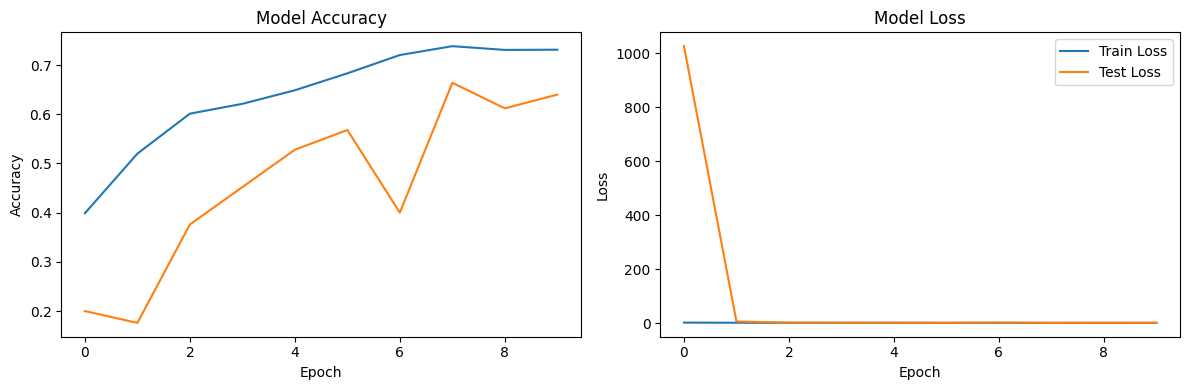

In [ ]:
# Plotting Training and Testing Accuracy and Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(y_true, y_pred, labels):
    accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Initializing arrays to hold the per-class metrics
    sensitivities = []
    specificities = []
    ppvs = []
    npvs = []

    # Calculate metrics for each class
    for class_index in range(len(labels)):
        tp = cm[class_index, class_index]
        fn = np.sum(cm[class_index, :]) - tp
        fp = np.sum(cm[:, class_index]) - tp
        tn = np.sum(cm) - (fp + fn + tp)

        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) != 0 else 0
        npv = tn / (tn + fn) if (tn + fn) != 0 else 0

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        ppvs.append(ppv)
        npvs.append(npv)

    # Calculating averages
    sensitivity = np.mean(sensitivities)
    specificity = np.mean(specificities)
    ppv = np.mean(ppvs)
    npv = np.mean(npvs)

    # Generating classification report
    class_report = classification_report(y_true, y_pred, target_names=labels)


    return([accuracy, sensitivity, specificity, ppv, npv, cm, class_report])

def map_predictions_to_strings(predictions, label_list):
    mapped_labels = [label_list[np.argmax(prediction)] for prediction in predictions]
    return mapped_labels

# Predictions
Y_pred_train_org = model.predict(X_train_org)
Y_pred_test = model.predict(X_test)

# mapping back to original form
Y_pred_train_org_mapped = map_predictions_to_strings(Y_pred_train_org, labels_list)
Y_pred_test_mapped = map_predictions_to_strings(Y_pred_test, labels_list)

# Evaluating on Train data
train_eval_resnet = evaluate_model(Y_train_org, Y_pred_train_org_mapped, labels_list)
print("## Training Set Metrics in NN:")
print()
print(f"Accuracy: {train_eval_resnet[0] * 100:.2f}%\n"
      f"Sensitivity: {train_eval_resnet[1]}\n"
      f"Specificity: {train_eval_resnet[2]}\n"
      f"PPV: {train_eval_resnet[3]}\n"
      f"NPV: {train_eval_resnet[4]}\n"
      f"Confusion Matrix:\n{train_eval_resnet[5]}\n"
      f"Classification Report:\n{train_eval_resnet[6]}")

print()
print()

# Evaluating on Test data
test_eval_resnet = evaluate_model(Y_test, Y_pred_test_mapped, labels_list)
print("\n## Test Set Metrics in NN:")
print()
print(f"Accuracy: {test_eval_resnet[0] * 100:.2f}%\n"
      f"Sensitivity: {test_eval_resnet[1]}\n"
      f"Specificity: {test_eval_resnet[2]}\n"
      f"PPV: {test_eval_resnet[3]}\n"
      f"NPV: {test_eval_resnet[4]}\n"
      f"Confusion Matrix:\n{test_eval_resnet[5]}\n"
      f"Classification Report:\n{test_eval_resnet[6]}")

8/8 [==============================] - 10s 1s/step
## Training Set Metrics in NN:

Accuracy: 67.44%
Sensitivity: 0.6744
Specificity: 0.9186
PPV: 0.7340232121352976
NPV: 0.9239730341136179
Confusion Matrix:
[[391   3   5  94   7]
 [108 115  41 216  20]
 [127  15 271  72  15]
 [ 37   1   2 424  36]
 [  5   0   2   8 485]]
Classification Report:
                  precision    recall  f1-score   support

            bear       0.59      0.78      0.67       500
 boa-constrictor       0.86      0.23      0.36       500
        bullfrog       0.84      0.54      0.66       500
golden-retriever       0.52      0.85      0.65       500
        goldfish       0.86      0.97      0.91       500

        accuracy                           0.67      2500
       macro avg       0.73      0.67      0.65      2500
    weighted avg       0.73      0.67      0.65      2500




## Test Set Metrics in NN:

Accuracy: 64.00%
Sensitivity: 0.64
Specificity: 0.9099999999999999
PPV: 0.6935224424698109
NPV: 0.9

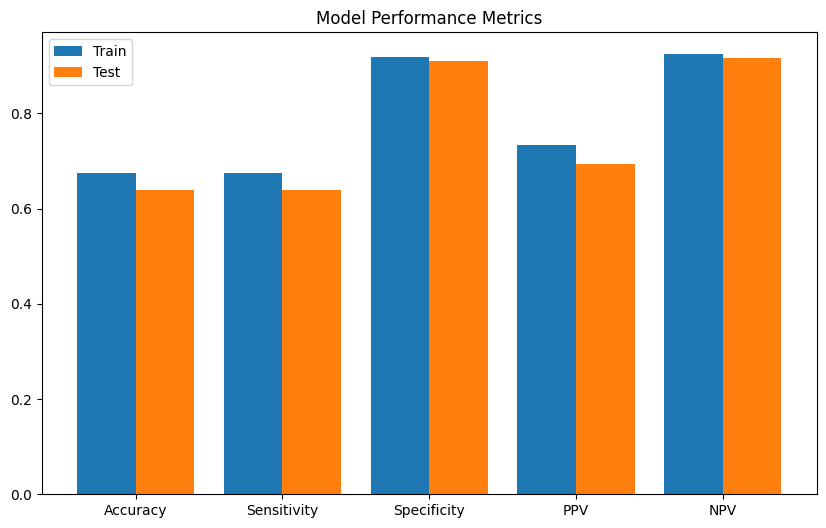

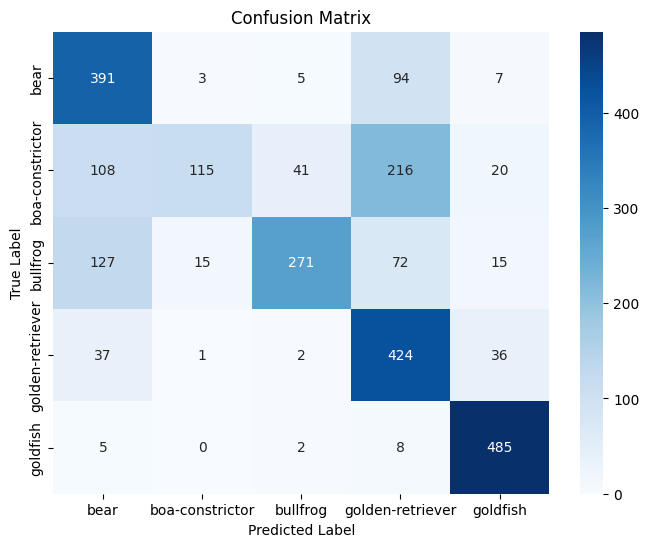

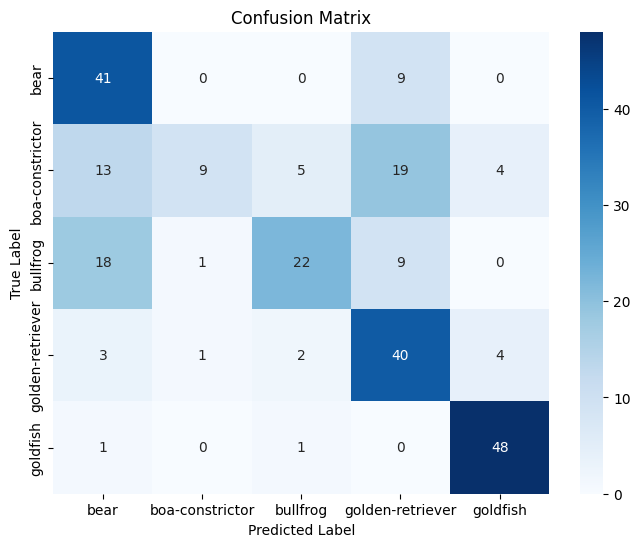

In [ ]:
def plot_metrics(train_metrics, test_metrics, metric_names):
    n_metrics = len(metric_names)
    x = range(n_metrics)

    plt.figure(figsize=(10, 6))
    plt.bar(x, train_metrics, width=0.4, label='Train', align='center')
    plt.bar([p + 0.4 for p in x], test_metrics, width=0.4, label='Test', align='center')
    plt.xticks([p + 0.2 for p in x], metric_names)
    plt.title('Model Performance Metrics')
    plt.legend()
    plt.show()

# Example usage
metric_names = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV']
train_metrics = [train_eval_resnet[0], train_eval_resnet[1], train_eval_resnet[2], train_eval_resnet[3], train_eval_resnet[4]]
test_metrics = [test_eval_resnet[0], test_eval_resnet[1], test_eval_resnet[2], test_eval_resnet[3], test_eval_resnet[4]]
plot_metrics(train_metrics, test_metrics, metric_names)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Example usage
plot_confusion_matrix(train_eval_resnet[5], labels_list)
plot_confusion_matrix(test_eval_resnet[5], labels_list)